In [4]:
import os

from models.vae import VariationalAutoencoder
from models.utils.loaders import load_mnist
import pandas as pd
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from matplotlib import pyplot as plt

disable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

N_DENSE = 2
L=32
TRAINING_FRACTION = 0.8

In [5]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"

In [6]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
#DATA_NAME = 'digits'
DATA_NAME = 'ising'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


In [7]:
df_bins = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/bins_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), sep="\t")
df_conf = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/spinConfigs_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), delimiter=r"\s+", header=None)

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3106: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
df_bins = df_bins[df_bins[' T '] != ' T ']

In [9]:
df_bins = df_bins.astype(
    {
        " T ": float,
        " binNum": int,
    }
)

## Get the temp and magnatization into the configuration dataframe

In [10]:
df_conf["T"] = df_bins[" T "]

In [11]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [12]:
df_conf["M"] = mean_col

In [13]:
filterned_confs = df_conf
#filterned_confs = df_conf[(df_conf["T"] < 1.5) | (df_conf["T"] > 4.5)]
#filterned_confs = df_conf[df_conf["T"] > 0.5]

In [14]:
filterned_confs.head()

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,T,M
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0


We need the data in the format: `(x_train, y_train), (x_test, y_test)`

In [15]:
train_with_meta_info = filterned_confs.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = filterned_confs.drop(index=train_with_meta_info.index)

In [16]:
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

# Check what MNIST data looked like

In [17]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [18]:
np.shape(x_train)

(60000, 28, 28, 1)

In [19]:
np.shape(x_train)

(60000, 28, 28, 1)

## Make our data the same

In [20]:
train.to_numpy().shape

(160000, 1024)

In [21]:
x = train.to_numpy().reshape(-1,L,L,1)
x_test = test.to_numpy().reshape(-1,L,L,1)

In [22]:
np.array([[1,1,1,1], [2,2,3,3], [4,4,5,5]]).reshape(-1,2,2,1)

array([[[[1],
         [1]],

        [[1],
         [1]]],


       [[[2],
         [2]],

        [[3],
         [3]]],


       [[[4],
         [4]],

        [[5],
         [5]]]])

In [23]:
x = x.astype(float)

In [24]:
x.shape

(160000, 32, 32, 1)

## Run Convolutional VAE

In [25]:
vae = VariationalAutoencoder(
    input_dim = (L,L,1)
    , encoder_conv_filters = [8,8,16]
    , encoder_conv_kernel_size = [3,3,3]
    , encoder_conv_strides = [1,2,1]
    , decoder_conv_t_filters = [16,8,1]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [1,2,1]
    , z_dim = 2
)

In [26]:
LEARNING_RATE = 0.0005
#R_LOSS_FACTOR = 1000
R_LOSS_FACTOR = 1000

In [27]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [28]:
BATCH_SIZE = 16
EPOCHS = 20
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [29]:
vae.train(     
    x
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Train on 160000 samples
Epoch 1/20


2022-09-09 12:19:58.956224: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-09 12:19:58.956261: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: owen-PRIME-Z390-A
2022-09-09 12:19:58.956266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: owen-PRIME-Z390-A
2022-09-09 12:19:58.956306: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-09-09 12:19:58.956523: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-09-09 12:19:58.956528: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-09-09 12:19:58.957866: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

   416/160000 [..............................] - ETA: 2:11 - loss: 1133.3970 - vae_r_loss: 1132.5515 - vae_kl_loss: 0.8456

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-09-09 12:19:59.321004: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-09-09 12:19:59.321024: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-09-09 12:19:59.329829: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-09 12:19:59.332493: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-09-09 12:19:59.336076: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/20220909-121958/plugins/profile/2022_09_09_12_19_59

2022-09-09 12:19:59.336688: I tensorflow/core/profiler/rpc/client/save_pro

159872/160000 [============================>.] - ETA: 0s - loss: 766.9623 - vae_r_loss: 763.9083 - vae_kl_loss: 3.0544
Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0002_ising/weights/weights-001-766.98.h5

Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0002_ising/weights/weights.h5
160000/160000 [==============================] - 56s 348us/sample - loss: 766.9842 - vae_r_loss: 763.9305 - vae_kl_loss: 3.0540 - lr: 5.0000e-04
Epoch 2/20
159968/160000 [============================>.] - ETA: 0s - loss: 763.8214 - vae_r_loss: 761.1165 - vae_kl_loss: 2.7049
Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0002_ising/weights/weights-002-763.84.h5

Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0002_ising/weights/weights.h5
160000/160000 [==============================] - 53s 328us/sample - loss: 763.8377 - vae_r_loss: 761.1329 - vae_kl_loss: 2.7048 - lr: 5.0000e-04
Epoch 3/20
159952/160000 [===========

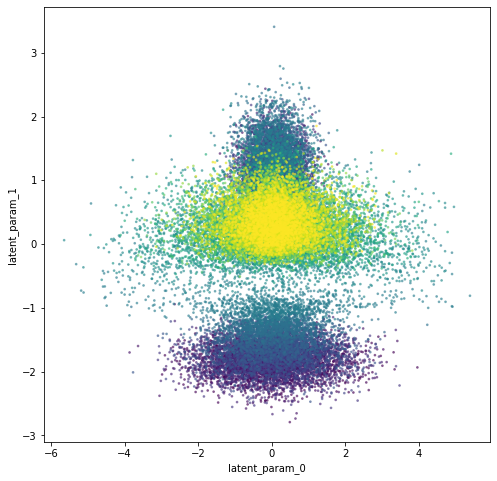

In [30]:
figsize = 8

z_points = vae.encoder.predict(x_test)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=test_with_meta_info['T'], alpha=0.5, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()

In [31]:
test_with_meta_info[test_with_meta_info['T'] < 2]

,0,1,2,3,4,5,6,7,8,9,...,1016,1017,1018,1019,1020,1021,1022,1023,T,M
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0000
10,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0000
27,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0000
33,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0000
46,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0.25,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69987,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.75,-0.7500
69988,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.75,-1.0000
69996,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.75,-1.0000
70002,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.75,-0.8750


In [32]:
test_with_meta_info[test_with_meta_info['T'] < 2].index

Int64Index([    5,    10,    27,    33,    46,    47,    49,    52,    54,
               56,
            ...
            69967, 69978, 69979, 69980, 69986, 69987, 69988, 69996, 70002,
            70005],
           dtype='int64', length=13993)

In [33]:
#len(x_test)
test_with_meta_info = test_with_meta_info.reset_index()

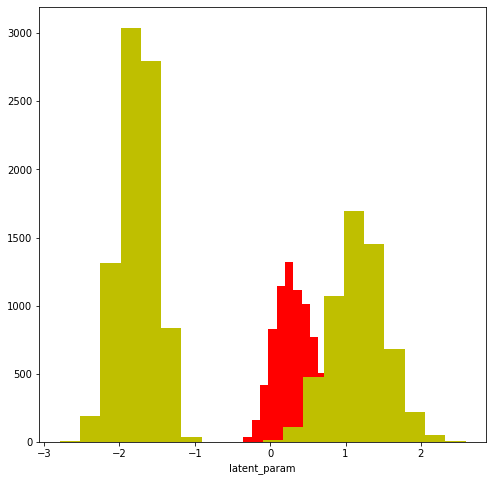

In [34]:
plt.figure(figsize=(figsize, figsize))
plt.hist(z_points[:, 1][test_with_meta_info[test_with_meta_info['T'] > 4].index], color='r', bins=20)
plt.hist(z_points[:, 1][test_with_meta_info[test_with_meta_info['T'] < 2].index], color='y', bins=20)
plt.xlabel("latent_param")
plt.savefig("{}/s3-bucket/reproduction/fig_2/vae_cnn_latent_param_hist_l{}.png".format(prefix_s3, L))

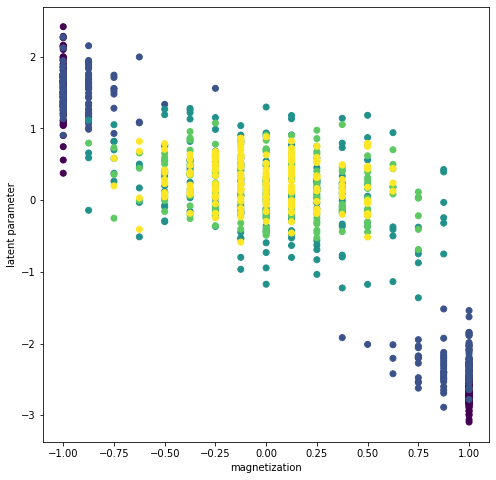

In [32]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(test_with_meta_info['M'], z_points[:,1], c=test_with_meta_info['T'])
plt.xlabel("magnetization")
plt.ylabel("latent parameter")
plt.savefig("{}/s3-bucket/reproduction/fig_2/vae_cnn_scatter_latent_vs_mag_color_by_t_l{}.png".format(prefix_s3, L))

# Check Recreate Input Output

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


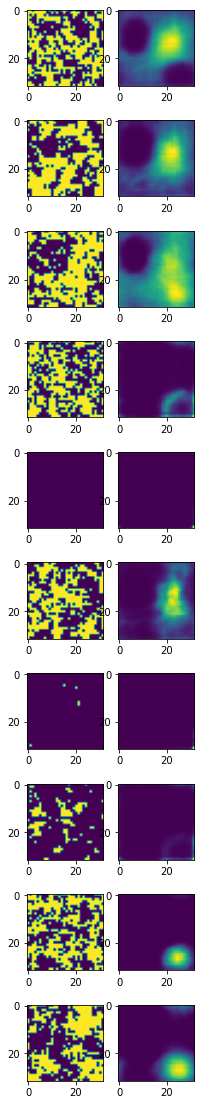

In [35]:
recreate_sample_size = 10

plt.figure(figsize=(3, recreate_sample_size*2))
    
rand_samp_idx = np.random.choice(range(len(x_test)), recreate_sample_size)
sampled_look = x_test[rand_samp_idx] 
sampled_latent_out = vae.model.predict(sampled_look)

for i in range(recreate_sample_size):
    
    plt1 = plt.subplot2grid((recreate_sample_size,2), (i,0), colspan=1)
    plt2 = plt.subplot2grid((recreate_sample_size,2), (i,1), colspan=1)
    
    plt1.imshow(
        sampled_look[i].reshape(L,L)
    )
    plt2.imshow(
        sampled_latent_out[i].reshape(L,L)
    )
